# Generation for NLP Baseline Code

## Install Packages

In [1]:
!pip install -r requirements.txt

## Import Necessary Libraries

In [2]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', None)

In [3]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## EDA

### Load Data

In [4]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('../data/cleaned_data.csv') 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [4]:
df.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None
1,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None
2,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None
3,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None
4,generation-for-nlp-431,(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르...,(가) 국가에 대한 설명으로 옳은 것은?,"[나 당연합군의 공격으로 멸망하였다 ., 9주 5소경의 지방 행정 구역을 두었다 ....",3,None


In [ ]:
# df를 저장해두기
#output_path = "../data/train_df.csv"
#df.to_csv(output_path, index = False)
#print(f"DataFrame saved as {output_path}")

DataFrame saved as ../data/train_df.csv


### Print missing values

In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2003
dtype: int64


### Basic information about the dataset

In [6]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2003 entries, 0 to 2002
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2003 non-null   object
 1   paragraph      2003 non-null   object
 2   question       2003 non-null   object
 3   choices        2003 non-null   object
 4   answer         2003 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 94.0+ KB


### EDA on 'question' and 'choices'

In [7]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)

### Question Length Distribution

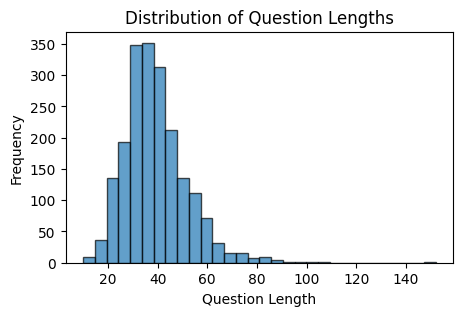

In [8]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering using TF-IDF

- TF-IDF 참고 링크: https://ko.wikipedia.org/wiki/Tf-idf

### Initialize TF-IDF Vectorizer

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

### Fit and transform the text data

In [10]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_question'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### Display the TF-IDF features

In [11]:
print("\nTF-IDF Features:")
display(tfidf_df.head(20))


TF-IDF Features:


10월  11월  12월  1450  1450년에서  1750  1750년  17세기  1960년대  1999년  19세기  1분기  \
0   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
1   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
2   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
3   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
4   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
5   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
6   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
7   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
8   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
9   0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
10  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
11  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
12  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
13  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
14  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
15  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
16  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
17  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
18  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   
19  0.0  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0   0.0  0.0   

     1월  1위를  2008년  2010년  2013년  2014  2014년  2014년도  2015학년도  2019  2019년  \
0   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
1   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
2   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
3   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
4   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
5   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
6   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
7   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
8   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
9   0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
10  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
11  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
12  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
13  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
14  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
15  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
16  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
17  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
18  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   
19  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0      0.0   0.0    0.0   

    2020  2020년  20세기  2분기  2에서  3분기   5년   5월  600  600년에서   7월  ceo가   eu  \
0    0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0   
1    0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0   
2    0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0   
3    0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0   
4    0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0   
5    0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0   
6    0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0

## Model Training

### Baseline Model

- https://huggingface.co/beomi/gemma-ko-2b

In [13]:
# 본인의 Huggingface auth token 입력
## Jupyter lab에서 로그인 하는 textbox가 나오지 않을 경우, terminal에서 로그인 하실 수 있습니다.
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): Traceback (most recent call last):
  File "/opt/conda/bin/huggingface-c

모델과 토크나이저를 불러옵니다.

In [12]:
model = AutoModelForCausalLM.from_pretrained(
    "beomi/gemma-ko-2b",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "beomi/gemma-ko-2b",
    trust_remote_code=True,
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#model = AutoModelForCausalLM.from_pretrained(
#    "beomi/Llama-3-Open-KO-8B",
#    torch_dtype=torch.float16,
#    trust_remote_code=True,
#)
#tokenizer = AutoTokenizer.from_pretrained(
#    "beomi/Llama-3-Open-KO-8B",
#    trust_remote_code=True,
#)

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

gemma-ko-2b 모델에는 chat template 이 없기 때문에 직접 입력해주어야 합니다.

In [13]:
tokenizer.chat_template = "{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user\n' + content + '<end_of_turn>\n<start_of_turn>model\n' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>\n' }}{% endif %}{% endfor %}"

### Prepare LoRA

In [14]:
peft_config = LoraConfig(
    r=6,
    lora_alpha=8,
    lora_dropout=0.05,
    target_modules=['q_proj', 'k_proj'],
    bias="none",
    task_type="CAUSAL_LM",
)

### Data Processing

In [10]:
dataset = Dataset.from_pandas(df)

In [11]:
PROMPT_NO_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

PROMPT_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

<보기>:
{question_plus}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

In [12]:
dataset

Dataset({
    features: ['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus'],
    num_rows: 2003
})

In [13]:
processed_dataset = []
for i in range(len(dataset)):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(dataset[i]["choices"])])

    # <보기>가 있을 때
    if dataset[i]["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            question_plus=dataset[i]["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            choices=choices_string,
        )

    # chat message 형식으로 변환
    processed_dataset.append(
        {
            "id": dataset[i]["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": f"{dataset[i]['answer']}"}
            ],
            "label": dataset[i]["answer"],
        }
    )


In [19]:
processed_dataset[0]

{'id': 'generation-for-nlp-425',
 'messages': [{'role': 'system', 'content': '지문을 읽고 질문의 답을 구하세요.'},
  {'role': 'user',
   'content': '지문:\n상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.\n\n질문:\n상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?\n\n선택지:\n1 - ㄱ, ㄴ\n2 - ㄱ, ㄷ\n3 - ㄴ, ㄹ\n4 - ㄷ, ㄹ\n\n1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n정답:'},
  {'role': 'assistant', 'content': '2'}],
 'label': 2}

In [15]:
processed_dataset = Dataset.from_pandas(pd.DataFrame(processed_dataset))
processed_dataset

Dataset({
    features: ['id', 'messages', 'label'],
    num_rows: 2003
})

In [16]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_dataset.map(
    tokenize,
    remove_columns=list(processed_dataset.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=True,
    desc="Tokenizing",
)

Tokenizing (num_proc=4):   0%|          | 0/2003 [00:00<?, ? examples/s]

NameError: name 'tokenizer' is not defined

In [22]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 2003
})

In [23]:
len(tokenized_dataset['input_ids'][0])

391

In [24]:
tokenized_dataset.filter(lambda x: len(x["input_ids"]) >= 1024)

Filter:   0%|          | 0/2003 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 367
})

In [25]:
tokenized_dataset.filter(lambda x: len(x["input_ids"]) <= 1024)

Filter:   0%|          | 0/2003 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1636
})

In [26]:
token_lengths = (len(tokenized_dataset[i]["input_ids"]) for i in range(len(tokenized_dataset)))
token_lengths

<generator object <genexpr> at 0x7f40fef02180>

In [27]:
# 데이터 분리
# vram memory 제약으로 인해 인풋 데이터의 길이가 1024 초과인 데이터는 제외하였습니다. *힌트: 1024보다 길이가 더 긴 데이터를 포함하면 더 높은 점수를 달성할 수 있을 것 같습니다!
tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]) <= 1024)  
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test']
# 데이터 확인
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=True))

Filter:   0%|          | 0/2003 [00:00<?, ? examples/s]

지문을 읽고 질문의 답을 구하세요.<start_of_turn>user
지문:
앞으로 주식시장 상장 전인 리츠(부동산 투자회사)도 부동산 개발사업에 투자할 수 있다. 의무배당 비율이 완화되고 수익증권이나 현물 등 현금이 아닌 배당도 가능해진다.국토교통부는 리츠 규제 완화 내용을 담은 ‘부동산 투자회사법’ 개정안이 국무회의를 통과했다고 23일 발표했다.개정안에 따르면 리츠는 상장 이전에도 개발사업에 투자할 수 있고 주주총회에서 특별결의를 통해 개발사업과 운영사업 간 비중을 정할 수 있다. 현재는 개발전문 리츠만 상장 전 개발사업에 투자할 수 있을 뿐 일반 리츠는 상장 후에만 개발사업 투자가 가능하다. 개발전문 리츠는 전체 자산의 70% 이상을, 일반 리츠는 전체 자산의 30% 이하만 개발사업에 투자해야 했다.이와 함께 상근 직원을 두고 직접 자산을 투자 및 운용하는 자기관리 리츠는 의무배당 비율이 90%에서 50%로 완화된다. 배당 의무도 완화된다. 지금은 리츠가 현금으로만 배당할 수 있지만 앞으로는 수익증권이나 현물로도 배당할 수 있다.개정안은 또 리츠가 차입할 때 자기자본 산정 기준일을 직전 분기로 정해놓은 것을 폐지하기로 했다. 기준일 이후에 투자를 받아 재무구조가 개선된 점을 반영할 수 있도록 하기 위해서다.이 밖에 사업 대상 부동산에 대해 감정평가를 의무적으로 받도록 한 규정은 유지하지만 한국감정원과 한국감정평가협회로부터 감정평가업자를 추천받도록 한 제도는 폐지키로 했다. 개정안은 국회 심의를 거쳐 확정, 공포되면 시행에 들어간다.

질문:
리츠(부동산 투자회사) 규제 완화 내용을 담은 법안의 이름은 무엇인가?

선택지:
1 - 부동산 투자회사법
2 - 자산관리법
3 - 주식시장법
4 - 부동산 개발법
5 - 금융투자법

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:<end_of_turn>
<start_of_turn>model
1<end_of_turn>



In [28]:
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=False))

<bos>지문을 읽고 질문의 답을 구하세요.<start_of_turn>user
지문:
앞으로 주식시장 상장 전인 리츠(부동산 투자회사)도 부동산 개발사업에 투자할 수 있다. 의무배당 비율이 완화되고 수익증권이나 현물 등 현금이 아닌 배당도 가능해진다.국토교통부는 리츠 규제 완화 내용을 담은 ‘부동산 투자회사법’ 개정안이 국무회의를 통과했다고 23일 발표했다.개정안에 따르면 리츠는 상장 이전에도 개발사업에 투자할 수 있고 주주총회에서 특별결의를 통해 개발사업과 운영사업 간 비중을 정할 수 있다. 현재는 개발전문 리츠만 상장 전 개발사업에 투자할 수 있을 뿐 일반 리츠는 상장 후에만 개발사업 투자가 가능하다. 개발전문 리츠는 전체 자산의 70% 이상을, 일반 리츠는 전체 자산의 30% 이하만 개발사업에 투자해야 했다.이와 함께 상근 직원을 두고 직접 자산을 투자 및 운용하는 자기관리 리츠는 의무배당 비율이 90%에서 50%로 완화된다. 배당 의무도 완화된다. 지금은 리츠가 현금으로만 배당할 수 있지만 앞으로는 수익증권이나 현물로도 배당할 수 있다.개정안은 또 리츠가 차입할 때 자기자본 산정 기준일을 직전 분기로 정해놓은 것을 폐지하기로 했다. 기준일 이후에 투자를 받아 재무구조가 개선된 점을 반영할 수 있도록 하기 위해서다.이 밖에 사업 대상 부동산에 대해 감정평가를 의무적으로 받도록 한 규정은 유지하지만 한국감정원과 한국감정평가협회로부터 감정평가업자를 추천받도록 한 제도는 폐지키로 했다. 개정안은 국회 심의를 거쳐 확정, 공포되면 시행에 들어간다.

질문:
리츠(부동산 투자회사) 규제 완화 내용을 담은 법안의 이름은 무엇인가?

선택지:
1 - 부동산 투자회사법
2 - 자산관리법
3 - 주식시장법
4 - 부동산 개발법
5 - 금융투자법

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:<end_of_turn>
<start_of_turn>model
1<end_of_turn>



In [29]:
train_dataset_token_lengths = [len(train_dataset[i]["input_ids"]) for i in range(len(train_dataset))]
print(f"max token length: {max(train_dataset_token_lengths)}")
print(f"min token length: {min(train_dataset_token_lengths)}")
print(f"avg token length: {np.mean(train_dataset_token_lengths)}")

max token length: 1023
min token length: 142
avg token length: 595.0726902173913


In [30]:
print(tokenizer.chat_template)

{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user
' + content + '<end_of_turn>
<start_of_turn>model
' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>
' }}{% endif %}{% endfor %}


Completion 부분만 학습하기 위한 data collator 설정

- 텍스트 중 response_template 까지는 ignore_index 로 loss 계산에서 제외
- 텍스트 중 response_template 이후는 학습에 포함 (정답 + eos 토큰)

In [31]:
response_template = "<start_of_turn>model"
data_collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template,
    tokenizer=tokenizer,
)

### Metric 설정

In [32]:
# 모델의 logits 를 조정하여 정답 토큰 부분만 출력하도록 설정
def preprocess_logits_for_metrics(logits, labels):
    logits = logits if not isinstance(logits, tuple) else logits[0]
    logit_idx = [tokenizer.vocab["1"], tokenizer.vocab["2"], tokenizer.vocab["3"], tokenizer.vocab["4"], tokenizer.vocab["5"]]
    logits = logits[:, -2, logit_idx] # -2: answer token, -1: eos token
    return logits

# metric 로드
acc_metric = evaluate.load("accuracy")

# 정답 토큰 매핑
int_output_map = {"1": 0, "2": 1, "3": 2, "4": 3, "5": 4}

# metric 계산 함수
def compute_metrics(evaluation_result):
    logits, labels = evaluation_result

    # 토큰화된 레이블 디코딩
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    labels = list(map(lambda x: x.split("<end_of_turn>")[0].strip(), labels))
    labels = list(map(lambda x: int_output_map[x], labels))

    # 소프트맥스 함수를 사용하여 로그트 변환
    probs = torch.nn.functional.softmax(torch.tensor(logits, dtype=torch.float32), dim=-1)
    predictions = np.argmax(probs, axis=-1)

    # 정확도 계산
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return acc

### Train

In [33]:
# pad token 설정
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.special_tokens_map

{'bos_token': '<bos>',
 'eos_token': '<eos>',
 'unk_token': '<unk>',
 'pad_token': '<eos>'}

In [34]:
tokenizer.padding_side = 'right'

sft_config = SFTConfig(
    do_train=True,
    do_eval=True,
    lr_scheduler_type="cosine",
    max_seq_length=1024,
    output_dir="../outputs_gemma",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,
    save_only_model=True,
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    peft_config=peft_config,
    args=sft_config,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [35]:
%%time

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.237300,0.168125,0.426829
2,0.113400,0.142447,0.426829
3,0.002800,0.150743,0.432927


CPU times: user 15min 49s, sys: 2min 35s, total: 18min 24s
Wall time: 18min 31s


TrainOutput(global_step=4416, training_loss=0.16164281846415238, metrics={'train_runtime': 1110.9988, 'train_samples_per_second': 3.975, 'train_steps_per_second': 3.975, 'total_flos': 3.1259360935950336e+16, 'train_loss': 0.16164281846415238, 'epoch': 3.0})

## Inference

In [17]:
# TODO 학습된 Checkpoint 경로 입력
checkpoint_path = "../outputs_gemma/checkpoint-2944"

model = AutoPeftModelForCausalLM.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
    # torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
# Load the test dataset
# TODO Test Data 경로 입력
test_df = pd.read_csv('../data/test.csv')

# Flatten the JSON dataset
records = []
for _, row in test_df.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
test_df = pd.DataFrame(records)

In [19]:
test_dataset = []
for i, row in test_df.iterrows():
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(row["choices"])])
    len_choices = len(row["choices"])
    
    # <보기>가 있을 때
    if row["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            question=row["question"],
            question_plus=row["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            question=row["question"],
            choices=choices_string,
        )

    test_dataset.append(
        {
            "id": row["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
            ],
            "label": row["answer"],
            "len_choices": len_choices,
        }
    )

In [20]:
%%time

infer_results = []

pred_choices_map = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"}

model.eval()
with torch.inference_mode():
    for data in tqdm(test_dataset):
        _id = data["id"]
        messages = data["messages"]
        len_choices = data["len_choices"]

        outputs = model(
            tokenizer.apply_chat_template(
                messages,
                tokenize=True,
                add_generation_prompt=True,
                return_tensors="pt",
            ).to("cuda")
        )

        logits = outputs.logits[:, -1].flatten().cpu()

        target_logit_list = [logits[tokenizer.vocab[str(i + 1)]] for i in range(len_choices)]

        probs = (
            torch.nn.functional.softmax(
                torch.tensor(target_logit_list, dtype=torch.float32)
            )
            .detach()
            .cpu()
            .numpy()
        )

        predict_value = pred_choices_map[np.argmax(probs, axis=-1)]
        infer_results.append({"id": _id, "answer": predict_value})

100%|██████████| 869/869 [16:50<00:00,  1.16s/it]

CPU times: user 15min 11s, sys: 1min 38s, total: 16min 50s
Wall time: 16min 50s


In [21]:
pd.DataFrame(infer_results).to_csv("output_cleaned_2944_2nd.csv", index=False)

In [25]:
pd.DataFrame(infer_results)

,id,answer
0,generation-for-nlp-0,1
1,generation-for-nlp-1,2
2,generation-for-nlp-2,4
3,generation-for-nlp-3,4
4,generation-for-nlp-4,4
...,...,...
864,generation-for-nlp-1609,1
865,generation-for-nlp-1512,1
866,generation-for-nlp-1382,3
867,generation-for-nlp-702,4
